# Deep Learning HW3:  Text Generation & Latent Space Visualization

## Part 1: (Song Lyrics Generation)

#### Import Libraries

In [ ]:
from google.colab import drive
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import random

#### Connect to Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


###  Study the data:
---


####  Importing the Dataset

We will import the dataset from Google Drive and load it into a pandas DataFrame.

In [ ]:
file_path = "/content/drive/MyDrive/Data/Songs.csv"
df = pd.read_csv(file_path)

# the first few rows of the dataset
df.head()

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new shit\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...


#### Counting Songs per Artist

In this step, we will analyze the dataset to determine how many songs each artist has.



In [ ]:
# Count the number of songs for each artist
artist_song_counts = df['Artist'].value_counts()

print("Number of songs per artist:\n")
for artist, count in artist_song_counts.items():
    print(f"{artist}: {count} songs")


Number of songs per artist:

Taylor Swift: 50 songs
David Bowie: 50 songs
Billy Joel: 50 songs
Eric Clapton: 50 songs
Billie Eilish: 50 songs
Leonard Cohen: 50 songs
Bruce Springsteen: 40 songs
The Beatles: 35 songs
Ray LaMontagne: 30 songs
Elton John: 30 songs
Queen: 30 songs
Frank Sinatra: 30 songs
John Denver: 30 songs
Bryan Adams: 30 songs
​twenty one pilots: 30 songs
Nat King Cole: 30 songs
Lana Del Rey: 30 songs
Vance Joy: 30 songs
George Michael: 30 songs
Bob Dylan: 20 songs
Ed Sheeran: 20 songs


#### Dataset Size and Song Count

In this step, we will check the size of the dataset.
We will also determine how many songs are in the dataset.

In [ ]:
num_rows, num_cols = df.shape
print(f"The dataset contains {num_rows} rows and {num_cols} columns.")

print(f"Total number of songs in the dataset: {num_rows}")


The dataset contains 745 rows and 3 columns.
Total number of songs in the dataset: 745


#### Analyzing Song Length

In this step, we will examine the length of the lyrics by calculating:

- The average number of characters in a song.
- The average number of words in a song=.

In [ ]:
# the avg of characters per song
avg_chars = df['Lyrics'].apply(len).mean()
print(f"Average number of characters per song: {avg_chars:.2f}")

# the avg of words per song
avg_words = df['Lyrics'].apply(lambda x: len(x.split())).mean()
print(f"Average number of words per song: {avg_words:.2f}")


Average number of characters per song: 1403.35
Average number of words per song: 276.26


#### Finding the Most Frequent Words

In this step, we will analyze the lyrics and determine the top 3 words that appear most frequently across all songs.

In [ ]:
all_lyrics = " ".join(df['Lyrics'].dropna()).lower()

# Tokenize the text
words = all_lyrics.split()

word_counts = Counter(words)
top_3_words = word_counts.most_common(3)

print("Top 3 most used words in the song lyrics:")
for word, count in top_3_words:
    print(f"{word}: {count} times")


Top 3 most used words in the song lyrics:
the: 8135 times
i: 6722 times
you: 6632 times


#### Creating a Word Cloud of Common Words

This cell generates a word cloud using the exact word frequencies from the dataset.

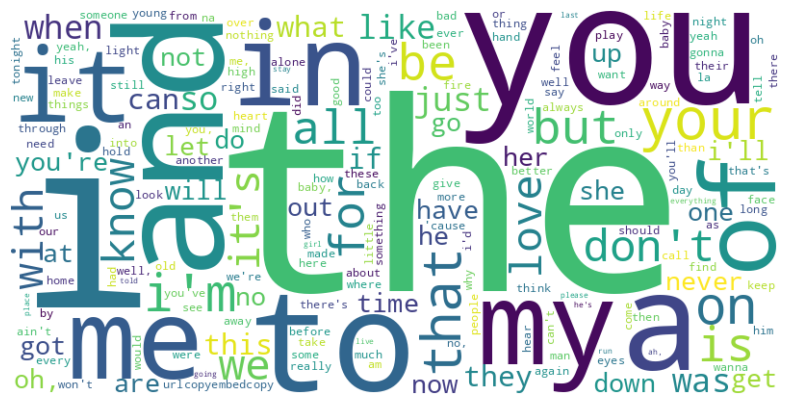

In [ ]:
word_freq = dict(word_counts)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

After studying the data, we will now move on to the 'Preprocessing' step to prepare it for model training.

###  Preprocessing:
---


#### Creating the Lyrics Corpus

In this step, we will create a corpus from the song lyrics.

In [ ]:
corpus = df['Lyrics'].dropna().tolist()

print(f"Corpus created with {len(corpus)} songs.")

print("\nSample lyrics from the corpus:\n")
print(corpus[0][:500])


Corpus created with 745 songs.

Sample lyrics from the corpus:

Vintage tee, brand new phone
High heels on cobblestones
When you are young, they assume you know nothing
Sequin smile, black lipstick
Sensual politics
When you are young, they assume you know nothing

But I knew you
Dancin' in your Levi's
Drunk under a streetlight, I
I knew you
Hand under my sweatshirt
Baby, kiss it better, I

And when I felt like I was an old cardigan
Under someone's bed
You put me on and said I was your favorite

A friend to all is a friend to none
Chase two girls, lose the on


#### Cleaning the Corpus

We will clean the lyrics by removing unwanted symbols, foreign characters, and unnecessary punctuation to prepare the data for processing.

In [ ]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\n+', ' ', text)  # Replace multiple newlines with space
    text = re.sub(r'[^a-z\s]', '', text)  # Keep only English letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

cleaned_corpus = [clean_text(lyrics) for lyrics in corpus]

print("First cleaned song lyrics:\n")
print(cleaned_corpus[0][:500])
print("\n" + "="*80 + "\n")
print("Second cleaned song lyrics:\n")
print(cleaned_corpus[1][:500])


First cleaned song lyrics:

vintage tee brand new phone high heels on cobblestones when you are young they assume you know nothing sequin smile black lipstick sensual politics when you are young they assume you know nothing but i knew you dancin in your levis drunk under a streetlight i i knew you hand under my sweatshirt baby kiss it better i and when i felt like i was an old cardigan under someones bed you put me on and said i was your favorite a friend to all is a friend to none chase two girls lose the one when you are


Second cleaned song lyrics:

i can see you standing honey with his arms around your body laughin but the jokes not funny at all and it took you five whole minutes to pack us up and leave me with it holdin all this love out here in the hall i think ive seen this film before and i didnt like the ending youre not my homeland anymore so what am i defending now you were my town now im in exile seein you out i think ive seen this film before ooh ooh ooh i can see you sta

#### Encoding the Lyrics for Model Training

Now that we have a cleaned corpus. We will:

- Tokenize the words to assign a unique index to each word.
- Convert the lyrics into sequences of numbers based on the word indices.

In [ ]:
# Create a vocabulary from the cleaned corpus
word_counts = Counter(" ".join(cleaned_corpus).split())
vocab = {word: i+1 for i, (word, _) in enumerate(word_counts.most_common())}

# Convert lyrics to sequences of numbers
encoded_corpus = [[vocab[word] for word in lyrics.split() if word in vocab] for lyrics in cleaned_corpus]

encoded_corpus_tensor = [torch.tensor(seq, dtype=torch.long) for seq in encoded_corpus]
index_to_word = {idx: word for word, idx in vocab.items()}

print(f"Vocabulary size: {len(vocab)} unique words.")
print("\nSample encoded lyrics (first 15 words):")
print(encoded_corpus_tensor[0][:15])

Vocabulary size: 9726 unique words.

Sample encoded lyrics (first 15 words):
tensor([3236, 5405,  932,  178,  803,  174, 1442,   14, 3987,   31,    2,   49,
         172,   36, 2422])


###  Model Definition and training:
---


#### Defining the LSTM Model for Lyrics Generation

Now, we will create an LSTM model, The model will:

- Take a sequence of words as input and predict the next word in the sequence.
- Use embeddings to represent words in a lower-dimensional space.
- Include LSTM layers to capture long-term dependencies in lyrics.
- Use a fully connected layer to generate predictions.

In [ ]:
class LyricsLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2):
        super(LyricsLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])  # Output from last time step
        return out, hidden

    def init_hidden(self, batch_size, device):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))


vocab_size = len(vocab) + 1  # +1 for padding token
model = LyricsLSTM(vocab_size)

print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"\nTotal number of trainable parameters: {total_params:,}")

LyricsLSTM(
  (embedding): Embedding(9727, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=9727, bias=True)
)

Total number of trainable parameters: 4,666,495


#### Setting Up the Loss Function and Optimizer



In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print(f"Loss Function: {loss_function}")
print(f"Optimizer: {optimizer}")

Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


#### Creating Input Sequences for Training

Since LSTMs work with sequences, we will create training sequences where:
- Each sequence contains a fixed number of words as input.
- The next word in the sequence is the target for training.

In [ ]:
seq_length = 20
input_sequences = []
target_words = []

for song in encoded_corpus:
    for i in range(len(song) - seq_length):
        input_sequences.append(song[i:i + seq_length])  # Input sequence
        target_words.append(song[i + seq_length])  # Next word as target

input_sequences = torch.tensor(input_sequences, dtype=torch.long)
target_words = torch.tensor(target_words, dtype=torch.long)

print(f"Total training sequences: {len(input_sequences)}")
print("\nSample input sequence (first 10 words):")
print(input_sequences[0][:10])
print("\nTarget word for the sample sequence:")
print(target_words[0])

Total training sequences: 190681

Sample input sequence (first 10 words):
tensor([3236, 5405,  932,  178,  803,  174, 1442,   14, 3987,   31])

Target word for the sample sequence:
tensor(395)


#### Training the LSTM Model on Lyrics Data

we will train the model for 100 epochs and track the training loss to monitor performance.

In [ ]:
batch_size = 64

dataset = TensorDataset(input_sequences, target_words)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

losses = []
for epoch in range(1, num_epochs + 1):
    total_loss = 0

    for batch_inputs, batch_targets in dataloader:
        batch_size = batch_inputs.size(0)
        hidden = model.init_hidden(batch_size, device)

        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

        optimizer.zero_grad()
        output, hidden = model(batch_inputs, hidden)  # Forward pass

        loss = loss_function(output, batch_targets.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)

    print(f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.4f}")
    # if epoch % 10 == 0:
    #     print(f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.4f}")

# torch.save(model.state_dict(), "/content/drive/MyDrive/lyrics_lstm.pth")

Epoch 1/100, Loss: 6.4795
Epoch 2/100, Loss: 6.0065
Epoch 3/100, Loss: 5.7106
Epoch 4/100, Loss: 5.4746
Epoch 5/100, Loss: 5.2724
Epoch 6/100, Loss: 5.0936
Epoch 7/100, Loss: 4.9281
Epoch 8/100, Loss: 4.7740
Epoch 9/100, Loss: 4.6276
Epoch 10/100, Loss: 4.4873
Epoch 11/100, Loss: 4.3509
Epoch 12/100, Loss: 4.2189
Epoch 13/100, Loss: 4.0908
Epoch 14/100, Loss: 3.9663
Epoch 15/100, Loss: 3.8451
Epoch 16/100, Loss: 3.7265
Epoch 17/100, Loss: 3.6107
Epoch 18/100, Loss: 3.4982
Epoch 19/100, Loss: 3.3881
Epoch 20/100, Loss: 3.2812
Epoch 21/100, Loss: 3.1767
Epoch 22/100, Loss: 3.0753
Epoch 23/100, Loss: 2.9753
Epoch 24/100, Loss: 2.8783
Epoch 25/100, Loss: 2.7850
Epoch 26/100, Loss: 2.6937
Epoch 27/100, Loss: 2.6039
Epoch 28/100, Loss: 2.5169
Epoch 29/100, Loss: 2.4326
Epoch 30/100, Loss: 2.3503
Epoch 31/100, Loss: 2.2709
Epoch 32/100, Loss: 2.1928
Epoch 33/100, Loss: 2.1181
Epoch 34/100, Loss: 2.0445
Epoch 35/100, Loss: 1.9732
Epoch 36/100, Loss: 1.9039
Epoch 37/100, Loss: 1.8373
Epoch 38/1

#### Visualizing Training Progress with Loss Plot

Now that the model training is complete, we will plot the training loss over epochs to analyze how well the model has learned.



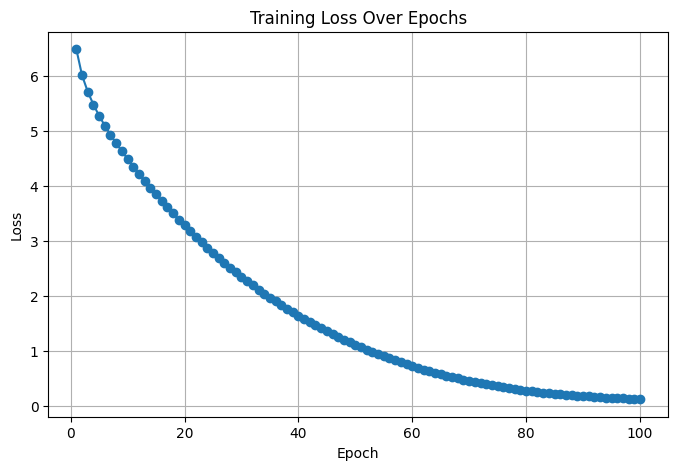

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()
plt.show()

###  Evaluation:
---


#### Generating Lyrics Using a Trained LSTM Model

This function generates lyrics by predicting one word at a time using the trained LSTM model.<br>
It allows three different sampling strategies:

- Top-K Sampling: Chooses the next word from the top `k` most probable words.
- Top-P (Nucleus) Sampling: Selects words from a dynamic set whose cumulative probability mass is below `p`.
- Greedy Sampling (Default): Always selects the most probable word.

In [ ]:
def LyricsGenerator(starting_string, char_count, top_k=None, top_p=None):

    model.eval()

    if not starting_string.strip():
        starting_string = random.choice(list(vocab.keys()))

    generated_text = starting_string


    input_sequence = [vocab.get(word, 0) for word in starting_string.split()]
    input_tensor = torch.tensor(input_sequence, dtype=torch.long).unsqueeze(0).to(device)

    hidden = model.init_hidden(1, device)  # Initialize LSTM hidden state

    for _ in range(char_count):
        with torch.no_grad():
            output, hidden = model(input_tensor, hidden)  # Forward pass through LSTM

        # Get probability distribution over vocabulary
        probs = F.softmax(output[-1], dim=-1)

        # Top-K Sampling
        if top_k:
            top_k_values, top_k_indices = torch.topk(probs, top_k)
            top_k_probs = F.softmax(top_k_values, dim=-1)  # Normalize probabilities
            word_idx = torch.multinomial(top_k_probs, 1).item()
            chosen_index = top_k_indices[word_idx].item()

        # Top-P Sampling
        elif top_p:
            sorted_probs, sorted_indices = torch.sort(probs, descending=True)
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

            # Ensure at least one word is selected
            top_p_mask = cumulative_probs <= top_p
            if not torch.any(top_p_mask):
                top_p_mask[0] = True  # Default to the most probable word if no others qualify

            top_p_probs = sorted_probs[top_p_mask]
            top_p_indices = sorted_indices[top_p_mask]
            word_idx = torch.multinomial(top_p_probs, 1).item()
            chosen_index = top_p_indices[word_idx].item()

        else:
            chosen_index = torch.argmax(probs).item()  # greedy sampling

        # Convert index back to a word
        next_word = index_to_word.get(chosen_index, "<UNK>")
        generated_text += " " + next_word

        input_tensor = torch.tensor([[chosen_index]], dtype=torch.long).to(device)

        if next_word == "<UNK>":
            break

    return generated_text


#### Evaluating the Model by Generating Lyrics

Now, we will evaluate our trained LSTM model by generating three different songs using the LyricsGenerator function.<br><br>


**Favorite Song Line for Generation:**



For **Song 2**, I chose the song **"bleeding"** with the starting line:  

**"give me a sign I don't wanna lose my mind"**


In [ ]:
song1_start = "it's not a silly little moment"
song2_start = "give me a sign I don't wanna lose my mind"
song3_start = ""

# Max character count based on previous calculations
max_characters = 1403

# Generate Song 1
song1_topk = LyricsGenerator(song1_start, char_count=max_characters, top_k=10)
song1_topp = LyricsGenerator(song1_start, char_count=max_characters, top_p=0.9)
song1_greedy = LyricsGenerator(song1_start, char_count=max_characters)

# Generate Song 2
song2_topk = LyricsGenerator(song2_start, char_count=max_characters, top_k=10)
song2_topp = LyricsGenerator(song2_start, char_count=max_characters, top_p=0.9)

# Generate Song 3
song3_topk = LyricsGenerator(song3_start, char_count=max_characters, top_k=10)
song3_topp = LyricsGenerator(song3_start, char_count=max_characters, top_p=0.9)

print("\n Song 1 - Top-K Sampling:\n", song1_topk)
print("\n Song 1 - Top-P Sampling:\n", song1_topp)

print("\n Song 2 - Top-K Sampling:\n", song2_topk)
print("\n Song 2 - Top-P Sampling:\n", song2_topp)

print("\n Song 3 - Top-K Sampling:\n", song3_topk)
print("\n Song 3 - Top-P Sampling:\n", song3_topp)



 Song 1 - Top-K Sampling:
 it's not a silly little moment you know she must never wanna end be with that foreign call a bad monkey up whether he gets bit says look dont be holding outside to they look dont matter where did please play how put it and where play games now play him where says he cant bring from any parked of house picture says bring down at the slide look beneath my feet singing high singing high pain ready to your mountains turn at any door hair any thousand friend in space like his thousand wait is high burning and deep darling id taste over theyd been met put any far and nice at turn years lips said so kept it was i said now everything i could change sure as he dont know one of he jim my boy he say he like his son said so not what he do what he looks and sorry have me what you must have lost an angel she say god she knows what they are theyre shiny there told she she thinks how much with them ever never people nobody far at pain singing im truth im feeling if ive love

#### Analysis of Top-K vs. Top-P Sampling

**Song 1: Starting with "it's not a silly little moment ..."**
- **Top-K Sampling (k=10):**  
  - The lyrics maintain **coherence**, but there is some **repetition**.  
  - Example: "dont be holding outside to they look dont matter where..."  
  - Words are selected from a **wider pool (k=10)**, adding **diversity** compared to smaller k-values.  

- **Top-P Sampling (p=0.9):**  
  - The lyrics **introduce more creativity** but can become **disjointed**.  
  - Example: "dreams you see open watch watch him back of silence ill see fire..."
  - **Unexpected word choices** lead to **more poetic but less structured output**.  

**Song 2: Starting with "give me a sign I don't wanna lose my mind"**
- **Top-K Sampling (k=10):**  
  - The lyrics are **controlled** and **slightly more varied** than k=5, but **still predictable**.  
  - Example: "id town to you remember you so an time you want like your heat ..."
  - Maintains **general theme**, but **lacks surprises**.  

- **Top-P Sampling (p=0.9):**  
  - More **expressive** but **prone to incoherent jumps**.  
  - Example: "when you never hold back from a long nights tight..."
  - Some sentences **make sense**, while others **feel randomly assembled**.  

**Song 3: Starting from Scratch (Empty String)**
- **Top-K Sampling (k=10):**  
  - Without context, the lyrics are **less structured**.  
  - Example: "this rain will you kill my can kill if this is full my dreams god knows..."
  - **Struggles with meaning**, though **some phrases sound poetic**.  

- **Top-P Sampling (p=0.9):**  
  - Generates **more surprising lyrics**, but **lacks thematic consistency**.  
  - Example: "lucy in the sky with diamonds..." suggests the model **recalls famous lyrics**.  
  - Tends to **lose direction quickly**, making it **chaotic**.


<br>

**After comparing both strategies:**

- **Top-K Sampling (k=10) provides a balance between coherence and diversity**, making it **suitable for structured lyrics generation**.
- **Top-P Sampling (p=0.9) is better for creative, unpredictable lyrics**, but **requires manual filtering** to ensure quality.

---


### **Past Strategies Tested But Not Used**

As part of this experiment, we tested different text generation strategies before selecting **Top-K (k=10) and Top-P (p=0.9)**. Below are some of the approaches we tested but did not use in our final evaluation.

#### **Greedy Sampling**
- **How it Works:**  
  - Always selects the word with the **highest probability** at each step.
- **Results:**  
  - The generated lyrics were **highly repetitive and lacked creativity**.  
  - Example output:  
    ```
    love you love you love you love you love you love you love you love you love you
    ```
  - **Why It Wasn’t Used:**  
    - Lacked **variation**, making the output **monotonous**.  
    - Couldn’t generate **diverse lyrics**.  

---

#### **Random Sampling (No Constraints)**
- **How it Works:**  
  - Selects the next word **randomly based on probabilities** without any restrictions.
- **Results:**  
  - The generated lyrics were **unpredictable and incoherent**.  
  - Example output:  
    ```
    sky bottle running whispers carrot walking loud whisper dreams
    ```
  - **Why It Wasn’t Used:**  
    - Too **chaotic**, making the lyrics **illogical**.  
    - Often selected **irrelevant words** that didn’t fit the theme.  

---

#### **Final Decision:**

After experimenting with different text generation methods, we have determined that **Top-K Sampling (`k=10`)** is the best approach for generating lyrics in our dataset, because it provides **the best balance of structure and diversity**, making it the **most reliable approach** for generating high-quality song lyrics in this dataset.